# Model Analysis

In the previous chapter, we introduced the basic use of `PyTorch` and use a neural network model to predict the probabilities of listed firms' tax non-compliance behaviors. Our previous model may be too simple, this leads to a bad prediction performance. By tunning the hyperparameters or regularizaition, we can further improve our model.

So in section 1- 4, we would introduce the implementation of $\ell_2$ regularization, dropout, early stopping and batch normalization. These techniques could help avoid over-fitting models. 

And in section 5, we tune hyperparameters and apply these methods to the example of tax non-compliant firms classfication. 

**Learning Goal**:
1. Implementing regularization methods including L2 penalty, dropout, early stopping;
2. Implementing batch normalization;
3. Tunning hyperparameters.

## Contents
* [0 - Import Packages and Data](#0)
* [1 - $\ell_2$ Regularization](#1)
* [2 - Dropout](#2)
* [3 - Early Stopping](#3)
* [4 - Batch Normalization](#4)
* [5 - Tunning](#5)

## 0 - Import Packages and Data

In [1]:
import pandas as pd # used for data import
import numpy as np # used for numerical operations
import torch # used for tensor operations
import torch.nn as nn # used for building neural networks
from torch.utils.data import DataLoader, TensorDataset # used for creating data loaders
from sklearn.preprocessing import StandardScaler # used for standardizing features
from sklearn.metrics import average_precision_score # used for evaluating models
import matplotlib.pyplot as plt # used for plotting PR curves
from sklearn.model_selection import train_test_split # used for splitting data into train/valiadtion sets
from utils import FNN, train, test # copy and paste FNN, train, test functions in last chapter to utils.py in your current working directory
import itertools # used for generating combinations of hyperparameters
import json # used for write output to txt

np.random.seed(42) # set random seed for reproducibility
torch.manual_seed(42)

Importing data is the same as what we do in last chapter. The only difference is we further split `train_df` into training data and validation data. Since validation data is used to evaluate the model performance and to choose hyperparameters.

In [2]:
# import csv
train_df = pd.read_csv('../全连接神经网络/train_data.csv') # import training data
test_df = pd.read_csv('../全连接神经网络/test_data.csv')

# split train_df into training and validation set
train_df, valid_df = train_test_split(train_df, 
                                      stratify=train_df['noncompliance'], 
                                      test_size=0.2, 
                                      random_state=42,
                                      shuffle=True)

# standardize the input
scaler = StandardScaler()
X_train_array = scaler.fit_transform(train_df.drop(['noncompliance'], axis=1))
X_valid_array = scaler.transform(valid_df.drop(['noncompliance'], axis=1))
X_test_array = scaler.transform(test_df.drop(['noncompliance'], axis=1))
y_train_array = train_df['noncompliance'].values
y_valid_array = valid_df['noncompliance'].values
y_test_array = test_df['noncompliance'].values

The procedures of preparing `train_loader` and `test_loader` are the same. For simplicity, we could define `prepare_loader()` function used to transform our array like data into DataLoader. 

In [3]:
def prepare_loader(X_array, y_array, batch_size, shuffle):
    """
    transform array data into DataLoader
    params:
        X_array: ndarray, feature;
        y_array: ndarray, label;
        batch_size: int, batch size;
        shuffle: bool, change the order of samples;
    return:
        loader: DataLoader, data including features and labels used in pytorch.
    """
    X_tensor = torch.tensor(X_array, dtype=torch.float32)
    y_tensor = torch.tensor(y_array, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

# prepare training, validation and test data
train_loader = prepare_loader(X_train_array, y_train_array, batch_size=128, shuffle=True)
valid_loader = prepare_loader(X_valid_array, y_valid_array, batch_size=128, shuffle=False)
test_loader = prepare_loader(X_test_array, y_test_array, batch_size=128, shuffle=False)

## 1 - $\ell_2$ Regularization

Recall the backpropagation of $\ell_2$ penalty:
$J_2 = \frac{\lambda}{2n} \sum_{l} ||W^{[l]}||_{F}^2$ 
and the derivative is 
$\frac{\partial J_2}{\partial W^{[l]}} = \frac{\lambda}{n} W^{[l]}.$
The update step for $\ell_2$ penalty is 
$$
W^{[l] (t+1)} = W^{[l] (t)} - \text{lr} \times (\text{grad}_{W^{[l]}} + \lambda \times W^{[l] (t)}).
$$

**In the optimizer without momentum** (e.g. `torch.optim.SGD`), we can implement $\ell_2$ regularization by adding $\lambda \times W$ to the gradients, instead of actually modifying the loss function. This can be done by setting the param `weight_decay`, which allows the optimizer to update parameters in the following way: 
$$
\text{param} = \text{param} - \text{lr} \times (\text{grad} + \text{weight decay} * \text{param})
$$

**In the optimizer with momentum** (e.g. `torch.optim.Adam`), `weight_decay` and $\ell_2$ regularization are different, see [Loshchilov and Hutter (2019)](https://arxiv.org/pdf/1711.05101) for more details. The solution is to use `torch.optim.AdamW` optimizer. 

Another notification is that `weight_decay` would apply on all the model parameters including bias. So, the following function classifies all the parameters into `decay` group and `no_decay` group, then return a list that can be directly passed to `torch.optim`.

In [4]:
def get_param_groups(model, weight_decay=3e-3):
    """
    group parameters that need weight_decay and no weight_decay
    params:
        model: nn.Module 
        weight_decay: float, weight_decay for weights parameters
    return:
        param_groups: list, parameter groups to optimizer
    """
    decay, no_decay = [], []
    for name, param in model.named_parameters():
        if 'bias' in name or 'bn' in name: # exclude bias and batch norm parameters from weight decay
            no_decay.append(param)
        else: # all other parameters (weights) will have weight decay
            decay.append(param)

    param_groups = [
        {'params': decay, 'weight_decay': weight_decay}, # set weight_decay for 'decay group'
        {'params': no_decay, 'weight_decay': 0.0} # set no weigth_decay for 'no decay group'
    ]
    return param_groups

We can implement $\ell_2$ regularization by modifying the optimizer: `optimizer = torch.optim.AdamW(get_param_groups(model, weight_decay=1e-4), lr=3e-4)`. In the following codes, we would see how the l2 norm of all weights would change as weight decay increases. 

Firstly, we define a function to calculate the l2 norm of all weights in a model.

In [5]:
def get_all_weights_l2norm(model):
    '''calculate l2 norm of all weights'''
    total_norm = 0.0
    for name, param in model.named_parameters():
        if 'weight' in name and param.requires_grad:
            total_norm += torch.norm(param, p=2) ** 2
    return total_norm.sqrt().item()

Then, we change `weight_decay` from 1e-4 to 1e-2. This is consistent with our intuition.

Training weight decay: 0.001
Epoch [50/500] Loss: 0.1369
Epoch [100/500] Loss: 0.1169
Epoch [150/500] Loss: 0.1072
Epoch [200/500] Loss: 0.0923
Epoch [250/500] Loss: 0.0836
Epoch [300/500] Loss: 0.0788
Epoch [350/500] Loss: 0.0689
Epoch [400/500] Loss: 0.0705
Epoch [450/500] Loss: 0.0601
Epoch [500/500] Loss: 0.0555
Training weight decay: 0.003
Epoch [50/500] Loss: 0.1272
Epoch [100/500] Loss: 0.1025
Epoch [150/500] Loss: 0.0876
Epoch [200/500] Loss: 0.0776
Epoch [250/500] Loss: 0.0661
Epoch [300/500] Loss: 0.0796
Epoch [350/500] Loss: 0.0634
Epoch [400/500] Loss: 0.0467
Epoch [450/500] Loss: 0.0401
Epoch [500/500] Loss: 0.0377
Training weight decay: 0.005
Epoch [50/500] Loss: 0.1304
Epoch [100/500] Loss: 0.1065
Epoch [150/500] Loss: 0.0934
Epoch [200/500] Loss: 0.0845
Epoch [250/500] Loss: 0.0819
Epoch [300/500] Loss: 0.0768
Epoch [350/500] Loss: 0.0696
Epoch [400/500] Loss: 0.0648
Epoch [450/500] Loss: 0.0587
Epoch [500/500] Loss: 0.0688
Training weight decay: 0.007
Epoch [50/500] Lo

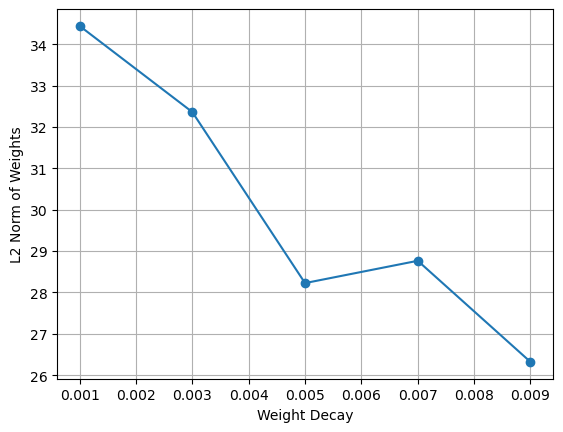

In [6]:
weight_decay_list = [1e-3, 3e-3, 5e-3, 7e-3, 9e-3]
l2_norm_results = [] # store l2 norm for each weight_decay

# Training loop for different weight_decay values
for wd in weight_decay_list:
    print(f'Training weight decay: {wd}')
    model = FNN()
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(get_param_groups(model, weight_decay=wd), lr=1e-3)
    train(model, train_loader, criterion, optimizer, num_epochs=500)
    norm_value = get_all_weights_l2norm(model)
    l2_norm_results.append(norm_value)

# plot weight_decay and l2 norm 
plt.plot(weight_decay_list, l2_norm_results, marker='o')
plt.xlabel('Weight Decay')
plt.ylabel('L2 Norm of Weights')
plt.grid(True)
plt.show()

## 2 - Dropout

We can implement dropout by modifying network structure. In the following codes, we define `FNN_dropout` a network with dropout layer.

In the `__init__` method, `self.dropout1 = nn.Dropout(p=0.5)` defines a dropout layer with dropout probability of 0.5, it would randomly zeroes some elements of the input with probability $p=0.5$ during training mode.

In the `forward` method, `x = self.dropout1(x)` applies the dropout operator to the output of first layer.

In [ ]:
class FNN_dropout(nn.Module):
    """
    A fully connected neural network with dropout.
    """
    def __init__(self):
        super(FNN_dropout, self).__init__()
        self.fc1 = nn.Linear(24, 64)
        self.dropout1 = nn.Dropout(p=0.5) # define dropout layer with 50% probability
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(p=0.3) # define dropout layer with 30% probability
        self.fc3 = nn.Linear(32, 8)
        self.dropout3 = nn.Dropout(p=0.1) # define dropout layer with 10% probability
        self.fc4 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x) # apply dropout
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x) # apply dropout
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x) # apply dropout
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
model_dropout = FNN_dropout()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=3e-4)
train(model_dropout, train_loader, criterion, optimizer, num_epochs=500)

## 3 - Early Stopping

Early Stopping technique monitors a model's metric (e.g. loss, auc) on a validation set and stops training when the metric starts to increase. The implementation of early stopping is easy, we start from defining a `EarlyStopping` class. This `EarlyStopping` class is a utility used for detect improment, save the best model and stop training if no improvement.

How it works:
- `__call__` method:
  1. On first call, records the initial validation loss and saves the model
  2. When improvement is detected (metric decreases by at least `delta`): Updates `best_metric` -> Saves the model -> Resets the patience counter
  3. When no improvement: Increments the `counter` -> Triggers stop if `patience` is exceeded
- `save_checkpoint` method:
  1. Saves the model's state dictionary to the specified path

In [ ]:
class EarlyStopping:
    '''
    Early stops training if metric doesn't imporve after patience (expect lower metric are better)
    '''
    def __init__(self, patience=50, delta=0, path='checkpoint.pt', verbose=False):
        self.patience = patience # number of epochs to wait since no improvement
        self.delta = delta # score reduction required to detect siginificant improvement
        self.counter = 0 # counter of patience
        self.stop = False # flag for stop training
        self.best_metric = None
        # self.verbose = verbose
        self.path = path # path to save the check point
    
    def __call__(self, valid_metric, model):
        if self.best_metric is None:
            # first call
            self.best_metric = valid_metric
            self.save_checkpoint(valid_metric, model)
        elif valid_metric < self.best_metric - self.delta:
            # significant improvement detect
            self.best_metric = valid_metric # update best loss
            self.save_checkpoint(valid_metric, model) # save the model
            self.counter = 0 # resets the patience counter
        else:
            # no significant improvement
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

    def save_checkpoint(self, valid_metric, model):
        '''save models when metric decreases'''
        # if self.verbose:
        #     print(f'loss improvement: {valid_metric:.6f}. Saving model.')
        torch.save(model.state_dict(), self.path)

We can implement early stopping by modifing previous `train` function in the following way:
1. instanciate a `EarlyStopping` class
2. loop until `num_epochs` or until early stopping triggers
   1. train the model (same as last chapter)
   2. get validation loss and probability using `test()` function
   3. call `early_stopping` 

In [ ]:
def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs, early_stop='loss'):
    '''
    train the model and early stopping on the validation loss
    params:
        model: the neural network model to train
        train_loader: DataLoader, training data;
        valid_loader: DataLoader, validation data;
        criterion: loss function;
        optimizer: optimization algorithm
        num_epochs: int, number of epochs
        early_stop: early stopping strategy:
                    - False: No early stopping
                    - 'loss': monitor validation loss
                    - 'auprc': monitor validation auprc
    return:
        model: trained model (best version if early stopping used)
        train_losses: list, training losses per epoch
        valid_losses: list, validation losses per epoch
    '''
    train_losses, valid_losses = [], [] # used to store loss of all epochs
    early_stopping = EarlyStopping() # initialize an EarlyStopping object

    for epoch in range(num_epochs):
        # train the model
        model.train()
        acc_train_loss = 0 # used to store training loss of all batches
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad() # clear previous gradients
            output = model(data) # forward propagation
            loss = criterion(output.squeeze(1), target) # calculate average batch loss
            loss.backward() # backpropagation
            optimizer.step() # update parameters
            acc_train_loss += loss.item() * data.size(0) # accumulate loss
        train_loss = acc_train_loss / len(train_loader.dataset) # calculate average epoch loss
        train_losses.append(train_loss)
        if (epoch + 1) % 50 == 0: # print loss each 50 epochs
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {train_loss:.4f}")

        # validate the model
        valid_loss, valid_probs = test(model, valid_loader, criterion)
        valid_losses.append(valid_loss)
        valid_auprc = average_precision_score(y_valid_array, valid_probs)

        # early stopping
        if early_stop:
            if early_stop == 'loss':
                early_stopping(valid_loss, model)
            elif early_stop == 'auprc':
                early_stopping(-valid_auprc, model)
            if early_stopping.stop:
                print(f'early stopping in epoch {epoch}.')
                break
            model.load_state_dict(torch.load('checkpoint.pt', weights_only=True)) # load the best model
    return model, train_losses, valid_losses
    

In the following codes, we train the model with early stopping. The training procedures stops at epoch 142, and epoch 92 has the minimum validation loss.

In [ ]:
model = FNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model, train_losses, valid_losses = train_and_validate(model, train_loader, valid_loader, criterion, optimizer, 500, early_stop=False)

We can plot the training loss and validation loss of all epochs. The training losses keep decreasing, but the validation loss begin increasing after epoch 92.

In [ ]:
plt.plot(range(len(train_losses)),train_losses, label='Training Loss')
plt.plot(range(len(valid_losses)),valid_losses,label='Validation Loss')
plt.axvline(valid_losses.index(min(valid_losses)), linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_losses))
plt.grid(True)
plt.legend()
plt.show()

## 4 - Batch Normalization

Batch normalization normalizes the inputs to each layer by re-centering them around zero and scaling them to a standard size. We can implement batch normalization by modifying the network structure.

In the `__init__` method, `self.bn1 = nn.BatchNorm1d(64)` defines a batch normalization over a 2D input with 64 features.

In the `forward` method, `x = torch.relu(self.bn1(self.fc1(x)))` firstly do the linear transformation, then apply batch normalization, and then do relu activation.

In [ ]:
class FNN_bn(nn.Module):
    """
    A fully connnected neural network with batch normalization
    """
    def __init__(self):
        super(FNN_bn, self).__init__()
        self.fc1 = nn.Linear(24, 64)
        self.bn1 = nn.BatchNorm1d(64) # defines batch normalization over a 2D input with 64 features
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32) # defines batch normalization over a 2D input with 32 features
        self.fc3 = nn.Linear(32, 8)
        self.bn3 = nn.BatchNorm1d(8) # defines batch normalization over a 2D input with 8 features
        self.fc4 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
model_bn = FNN_bn()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_bn.parameters(), lr=3e-4)
train(model_bn, train_loader, criterion, optimizer, num_epochs=500)

## 5 - Tunning

There are many third-party libraries that can help you automatically tunning hyperparameters. Here, we tune by hands.

Firstly, we define a parameters grid containing all the possible values of hyperparameters. Since `hidden_layers` and `dropout_rates` must have the same length, after expanding the grid, we need to filter out the combinations with different `hidden_layers` and `dropout_rates` lengths.

In [ ]:
# all the values of hyperparameters to be trained
param_grid = {
    'batch_size': [256, 128, 64],
    'hidden_layers': [[64, 32, 16], [32, 8]], # number of neurons in each hidden layers
    'dropout_rates': [[0, 0, 0], [0, 0]],
    'batch_norm': [True, False],
    'criterion': ['BCE'],
    'optimizer': ['Adam'],
    'lr': [3e-3, 1e-3, 3e-4],
    'weight_decay': [0, 1e-4, 3e-4],
    'num_epochs': [100, 300, 500],
    'early_stop': ['auprc', False],
}

# expand the grid to combinations
keys, values = zip(*param_grid.items())
all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# filter out combination that hidden_layers and dropout_rates have different lengths
all_combinations = [
    combo for combo in all_combinations 
    if len(combo['hidden_layers']) == len(combo['dropout_rates'])
]

Secondly, we build a flexible neural network `Net`, its architecture depends on the input parameters `input_dim`, `hidden_layers`, `dropout_rates` and `use_batchnorm`.

`__init__` method:
1. Iterates through each specified hidden layer size
2. For each layer, adds:
    1. Linear transformation (nn.Linear)
    2. Batch normalization (if enabled)
    3. ReLU activation
    4. Dropout (if `dropout_rates > 0`)
3. Final linear layer reduces to 1 output neuron
4. Sigmoid activation for binary classification




In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rates, use_batchnorm=False):
        '''
        params:
            input_dim: int, dimension of input features;
            hidden_layers: list, number of neurons for each hidden layers;
            dropout_rates: list, same length as hidden_layers, dropout probability for each hidden layer;
            use_batchnorm: bool, use batch normalization in each layer.
        '''
        super(Net, self).__init__()
        layers = [] # store all the layers
        prev_dim = input_dim
        for i, hidden_dim in enumerate(hidden_layers): # loop over hidden layers
            layers.append(nn.Linear(prev_dim, hidden_dim)) # add linear layer
            if use_batchnorm: # if enable batch normalization
                layers.append(nn.BatchNorm1d(hidden_dim)) # add batch normalization layer
            layers.append(nn.ReLU()) # add ReLu activation
            if dropout_rates[i] > 0: # if enable dropout
                layers.append(nn.Dropout(dropout_rates[i])) # add dropout layer
            prev_dim = hidden_dim 
        layers.append(nn.Linear(prev_dim, 1)) # add linear layer
        layers.append(nn.Sigmoid()) # sigmoid transformation to output probability
        self.network = nn.Sequential(*layers) # combining layers into a container
    
    def forward(self, x):
        return self.network(x) # pass input sequentially through all the layers

Thirdly, we define a `tune()` function. This function would loop over all the hyperparameter combinations and calculate the validation loss, then write the information to `output_file`.

How it works:
1. prepare train_loader and valid_loader based on `batch_size`;
2. build network based on `hidden_layers`, `dropout_rates` and `batch_norm`;
3. prepare loss function and optimizer based on;
4. train the model using `train_and_validate`
5. save information (hyperparaters and validation loss) to `output_file`. 

In [ ]:
def tune(combinations, output_file='output.txt'):
    '''
    loop over combinations and calculate validation loss 
    params:
        combindations: list, each element is a dict containing hyperparameter's name and value;
        output_file: file path to save the output.
    return:
        None
    '''
    with open(output_file, 'w') as f: # clean output_file
        pass

    for config in combinations:
        print(f'config: {config}')
    
        # prepare data
        train_loader = prepare_loader(X_train_array, y_train_array, batch_size=config['batch_size'], shuffle=True)
        valid_loader = prepare_loader(X_valid_array, y_valid_array, batch_size=config['batch_size'], shuffle=False)
        
        # build model
        model = Net(
            input_dim=next(iter(train_loader))[0].shape[1],
            hidden_layers=config['hidden_layers'],
            dropout_rates=config['dropout_rates'],
            use_batchnorm=config['batch_norm']
        )
        
        # loss
        if config['criterion'] == 'BCE':
            criterion = nn.BCELoss()
        else:
            raise ValueError('Unknown criterion')
        
        # optimizer
        if config['optimizer'] == 'Adam':
            optimizer = torch.optim.Adam(get_param_groups(model, weight_decay=config['weight_decay']), lr=config['lr'])
        else:
            raise ValueError("Unknown optimizer")
        
        # train & validate
        model, _, _ = train_and_validate(model, train_loader, valid_loader, criterion, optimizer, config['num_epochs'], config['early_stop'])
        
        # save results
        valid_loss, pred_probs = test(model, valid_loader, criterion)
        config['valid_loss'] = valid_loss
        valid_auprc = average_precision_score(y_valid_array, pred_probs)
        result = {**config, "valid_auprc": valid_auprc}

        with open(output_file, 'a') as f:
            f.write(json.dumps(result) + '\n')

In [ ]:
tune(all_combinations)